In [19]:
import numpy as np
import pickle
import matplotlib.pyplot as plt
from pylab import rcParams
from sklearn.cluster import KMeans, DBSCAN
from sklearn.mixture import GaussianMixture
from collections import Counter
import umap
import networkx as nx
from itertools import permutations 
import hdbscan
import numba

In [11]:
class Profile():
    def __init__(self, filename):
        self._metadata = {}
        self._projects = {}
        self._votes = {}
        with open(filename, "r", encoding="utf8") as self.file:
            self.__read_lines()

        self.__convert_projects()
        self.__convert_votes()
        
    @property
    def ballots(self):
        return self._ballots
        
    def __convert_projects(self):
        self._projectid_to_index = {}
        tmp = {}
        for i, (proj_id, budget) in enumerate(self._projects.items()):
            self._projectid_to_index[proj_id] = i
            tmp[i] = budget
        self._projects = tmp
        
    def __convert_votes(self):
        self._votes = [np.array([self._projectid_to_index[x]]) if isinstance(x, int) else np.array([self._projectid_to_index[int(y)] for y in x.split(",")]) for x in self._votes.values()]
        self._ballots = np.zeros((self._metadata["num_votes"], self._metadata["num_projects"]))
        for i, vote in enumerate(self._votes):
            self._ballots[i,vote] = 1
       
    def __read_lines(self):
        _sections = {"META":self._metadata, 
                     "PROJECTS":self._projects, 
                     "VOTES":self._votes}
        _slices = {"key":"value",
                   "project_id":"cost",
                   "voter_id":"vote"}
        
        for line in self.file:
            line = line.strip()

            items = line.split(";")
            # find the right index for one of the properties (value, cost, vote)
            try:
                index = items.index(_slices[items[0]])
            except KeyError:
                pass
            else:
                continue 
            
            # switch to a new dict when a new section is found
            try: 
                _current = _sections[line]
            except KeyError:
                pass
            else:
                continue
            
            # read data
            try:
                try:
                    key = int(items[0])
                except ValueError:
                    key = items[0]
                _current[key] = int(items[index])
            except IndexError:
                pass
            except ValueError:
                _current[key] = items[index]

In [12]:
with open("data//sorted_files.pkl", 'rb') as f:
    file_division = pickle.load(f)

In [13]:
approval_profile_files = sorted(file_division['approval'], key=lambda x: x[2], reverse=True)

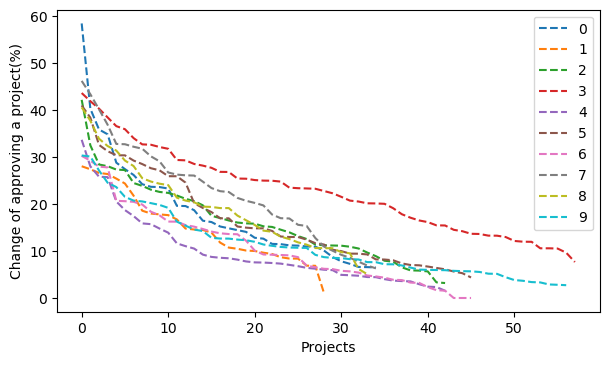

In [14]:
rcParams['figure.figsize'] = 7, 4
rcParams['figure.dpi'] = 100
rcParams.update({'font.size': 10})
for i in range(10):
    x = Profile(approval_profile_files[i][0])
    plt.plot(x.ballots.mean(0)*100,'--',label=i)
plt.legend()
plt.xlabel("Projects")
plt.ylabel("Change of approving a project(%)")
plt.show()

In [15]:
i = 0
old_data = Profile(approval_profile_files[i][0]).ballots

# data = [x/sum(x) if sum(x) else x for x in old_data]
data = old_data

In [16]:
x,y = np.unique(data, return_counts=True, axis=0)
len(y), len(data)
# sorted(y, reverse=True)

(6236, 8700)

In [33]:
@numba.njit()
def XOR_dist(a,b):
    XOR = np.logical_xor(a,b).sum()
    OR =  np.logical_or(a,b).sum()
    AND = np.logical_and(a,b).sum() 
    avg = (a.sum() + b.sum()) / 2
#     return avg - AND
    return (avg - AND) / (avg + AND)
    return len(a) - AND
    return (len(a) - AND) / (len(a) + AND)
    return (len(a) - AND) / (len(a) + AND) + XOR / (5*len(a))

reducer = umap.UMAP(n_components=2, n_neighbors=15, metric=XOR_dist)
reducer.fit(data)
embedding = reducer.transform(data)
# Verify that the result of calling transform is
# idenitical to accessing the embedding_ attribute
assert(np.all(embedding == reducer.embedding_))
embedding.shape

/home/jonne/anaconda3/lib/python3.7/site-packages/umap/umap_.py:1495: UserWarning: custom distance metric does not return gradient; inverse_transform will be unavailable. To enable using inverse_transform method method, define a distance function that returns a tuple of (distance [float], gradient [np.array])
  "custom distance metric does not return gradient; inverse_transform will be unavailable. "


(8700, 2)

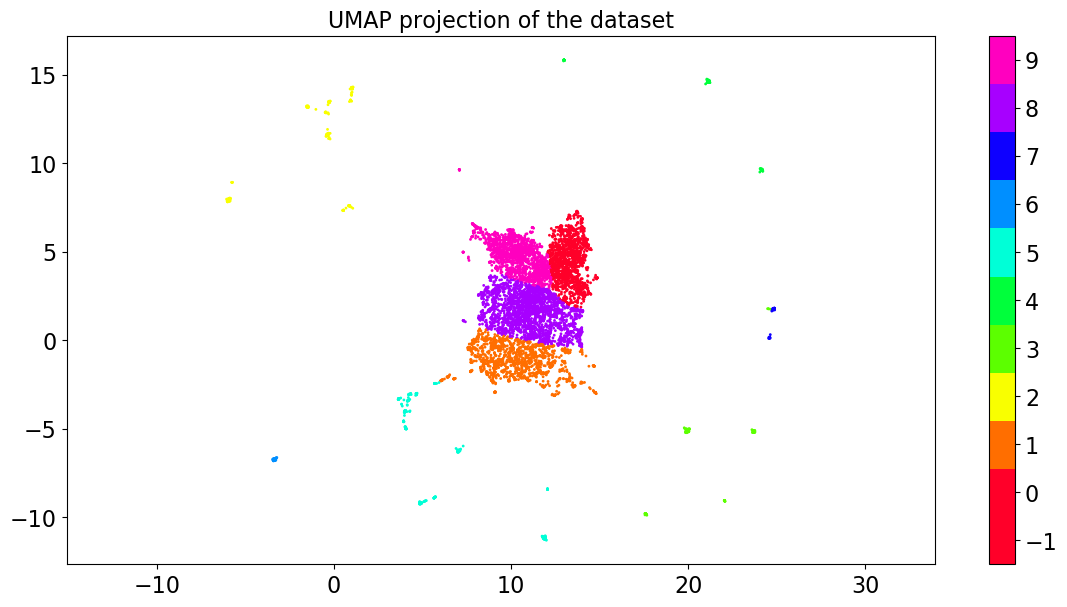

In [34]:
# n_clusters = 10
# k = KMeans(n_clusters).fit(embedding)

n_clusters = 10
k = GaussianMixture(n_clusters).fit(embedding)
k.labels_ = k.predict(embedding)

# k = DBSCAN(0.45, len(data)//250).fit(embedding)
# n_clusters = max(k.labels_) + 1

# k = hdbscan.HDBSCAN(min_cluster_size=len(data)//100, gen_min_span_tree=True).fit(embedding)
# n_clusters = max(k.labels_) + 1

# # Visualization of HDBSCAN
# import seaborn as sns
# k.minimum_spanning_tree_.plot(edge_cmap='viridis',
#                                       edge_alpha=0.6,
#                                       node_size=10,
#                                       edge_linewidth=1)
# plt.show()

# k.condensed_tree_.plot()
# plt.show()

# k.condensed_tree_.plot(select_clusters=True, selection_palette=sns.color_palette())
# plt.show()

rcParams['figure.figsize'] = 14, 7
rcParams['figure.dpi'] = 100
rcParams.update({'font.size': 16})

plt.scatter(embedding[:, 0], embedding[:, 1], c=k.labels_, s=1, cmap='gist_rainbow')
plt.gca().set_aspect('equal', 'datalim')
plt.colorbar(boundaries=np.arange(-1, n_clusters+1)-0.5).set_ticks(np.arange(-1, n_clusters))
plt.title('UMAP projection of the dataset', fontsize=16)
plt.show()

if embedding.shape[1] >= 4:
    plt.scatter(embedding[:, 2], embedding[:, 3], c=k.labels_, s=1, cmap='gist_rainbow')
    plt.gca().set_aspect('equal', 'datalim')
    plt.colorbar(boundaries=np.arange(-1, n_clusters+1)-0.5).set_ticks(np.arange(-1, n_clusters))
    plt.title('UMAP projection of the dataset', fontsize=16)

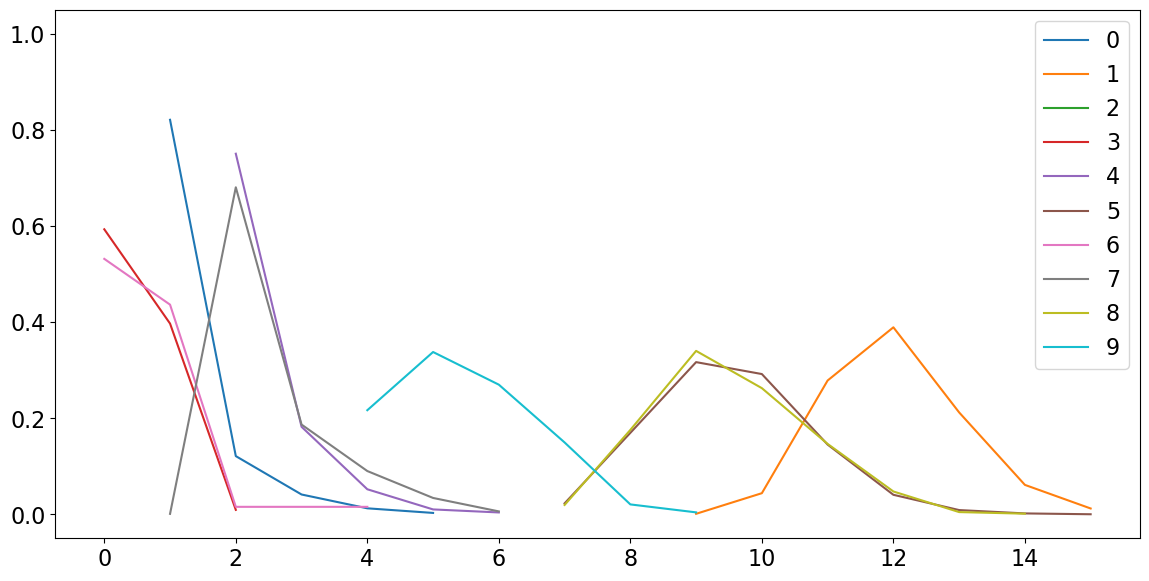

In [31]:
# print(f"number of approvals per cluster: {np.sum(cluster_mean, 1)}")
n_clusters = max(k.labels_) + 1

cluster_size = Counter(k.labels_) 

distance = {i:{} for i in range(-1,n_clusters)}
cluster_centers_ = [np.mean(old_data[k.labels_ == i],0) for i in range(n_clusters)]
for c, ballot in zip(k.labels_, old_data):
    dis = int(np.abs(ballot - cluster_centers_[c]).sum())
    try:
        distance[c][dis] += 1/cluster_size[c]
    except KeyError:
        distance[c][dis] = 1/cluster_size[c]
        
for c, dist in distance.items():
    plt.plot(*zip(*sorted(dist.items())), label=c)
plt.legend()
plt.show()

0
{0: 0.003194888178913738, 1: 0.3961661341853035, 2: 0.003194888178913738, 3: 0.006389776357827476, 4: 0.003194888178913738, 5: 0.0, 6: 0.4281150159744409, 7: 0.0, 8: 0.006389776357827476, 9: 0.006389776357827476, 10: 0.006389776357827476, 11: 0.0, 12: 0.0, 13: 0.003194888178913738, 14: 0.009584664536741214, 15: 0.003194888178913738, 16: 0.009584664536741214, 17: 0.006389776357827476, 18: 0.003194888178913738, 19: 0.0, 20: 0.06070287539936102, 21: 0.006389776357827476, 22: 0.003194888178913738, 23: 0.003194888178913738, 24: 0.0, 25: 0.0, 26: 0.01597444089456869, 27: 0.0, 28: 0.07028753993610223, 29: 0.006389776357827476, 30: 0.0, 31: 0.0, 32: 0.14057507987220447, 33: 0.0, 34: 0.0}
313


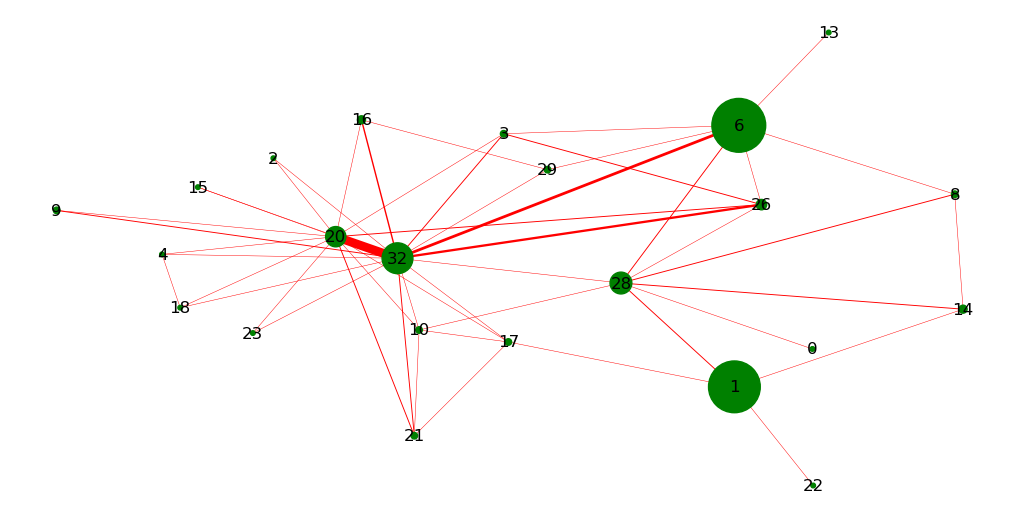

1
{0: 0.830567081604426, 1: 0.5435684647302904, 2: 0.533195020746888, 3: 0.5511756569847857, 4: 0.3644536652835408, 5: 0.3852005532503458, 6: 0.20470262793914246, 7: 0.7247579529737206, 8: 0.38105117565698476, 9: 0.318118948824343, 10: 0.32503457814661135, 11: 0.2607192254495159, 12: 0.19432918395573998, 13: 0.334716459197787, 14: 0.326417704011065, 15: 0.14453665283540804, 16: 0.1016597510373444, 17: 0.30013831258644535, 18: 0.6002766251728907, 19: 0.5733056708160442, 20: 0.14107883817427386, 21: 0.25933609958506226, 22: 0.28492392807745504, 23: 0.5013831258644537, 24: 0.0995850622406639, 25: 0.2717842323651452, 26: 0.1251728907330567, 27: 0.11134163208852006, 28: 0.24412171507607192, 29: 0.13831258644536654, 30: 0.18464730290456433, 31: 0.2745504840940526, 32: 0.0656984785615491, 33: 0.1355463347164592, 34: 0.0698478561549101}
1446


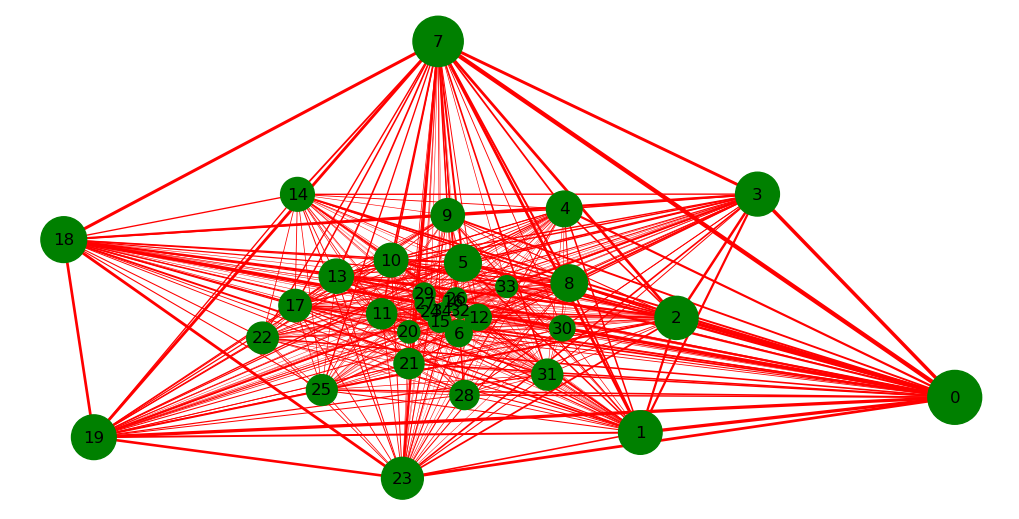

2
{0: 0.0, 1: 0.0, 2: 1.0, 3: 0.0, 4: 0.0, 5: 0.0, 6: 0.0, 7: 0.0, 8: 0.0, 9: 0.0, 10: 0.0, 11: 0.0, 12: 0.0, 13: 0.0, 14: 0.0, 15: 0.0, 16: 0.0, 17: 0.0, 18: 0.0, 19: 0.0, 20: 0.0, 21: 0.0, 22: 0.0, 23: 0.0, 24: 0.0, 25: 0.0, 26: 0.0, 27: 0.0, 28: 0.0, 29: 0.0, 30: 0.0, 31: 0.0, 32: 0.0, 33: 0.0, 34: 0.0}
79


/home/jonne/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/jonne/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


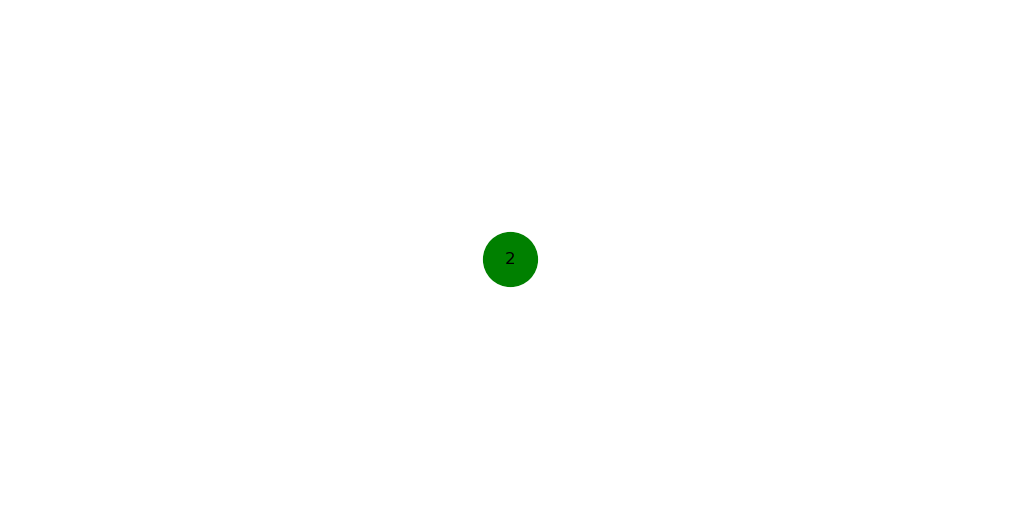

3
{0: 0.6076555023923444, 1: 0.0, 2: 0.0, 3: 0.0, 4: 0.0, 5: 0.0, 6: 0.0, 7: 0.0, 8: 0.0, 9: 0.0, 10: 0.0, 11: 0.004784688995215311, 12: 0.0, 13: 0.004784688995215311, 14: 0.009569377990430622, 15: 0.0, 16: 0.3923444976076555, 17: 0.004784688995215311, 18: 0.0, 19: 0.0, 20: 0.0, 21: 0.0, 22: 0.0, 23: 0.0, 24: 0.0, 25: 0.0, 26: 0.0, 27: 0.0, 28: 0.0, 29: 0.0, 30: 0.0, 31: 0.0, 32: 0.0, 33: 0.0, 34: 0.0}
209


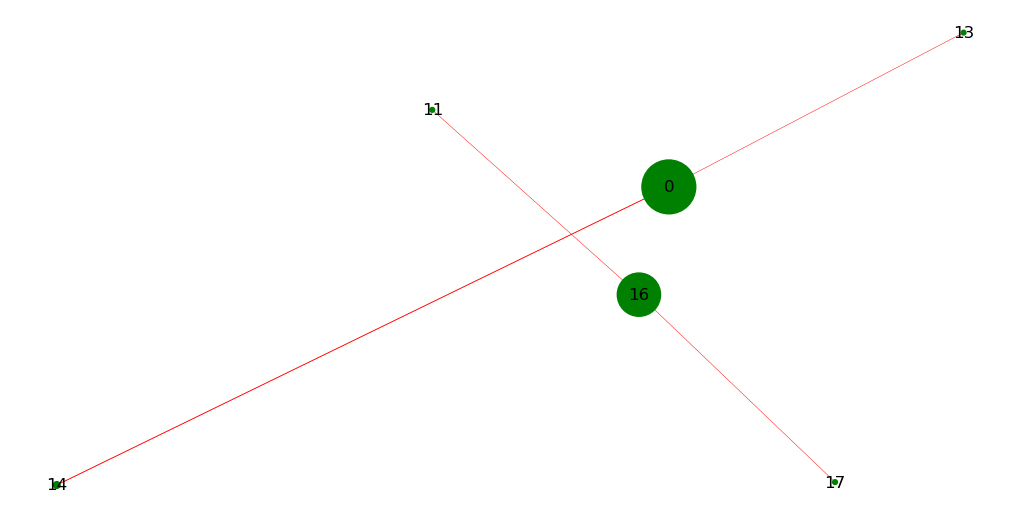

4
{0: 0.041928721174004195, 1: 0.033542976939203356, 2: 0.029350104821802937, 3: 0.03773584905660377, 4: 0.031446540880503145, 5: 0.26834381551362685, 6: 0.0041928721174004195, 7: 0.008385744234800839, 8: 0.24737945492662475, 9: 0.22641509433962265, 10: 0.05660377358490566, 11: 0.006289308176100629, 12: 0.0041928721174004195, 13: 0.03563941299790356, 14: 0.0041928721174004195, 15: 0.014675052410901468, 16: 0.04821802935010482, 17: 0.006289308176100629, 18: 0.0041928721174004195, 19: 0.0, 20: 0.0020964360587002098, 21: 0.11740041928721175, 22: 0.0041928721174004195, 23: 0.0, 24: 0.016771488469601678, 25: 0.05660377358490566, 26: 0.023060796645702306, 27: 0.16561844863731656, 28: 0.008385744234800839, 29: 0.014675052410901468, 30: 0.0041928721174004195, 31: 0.008385744234800839, 32: 0.0041928721174004195, 33: 0.0041928721174004195, 34: 0.014675052410901468}
477


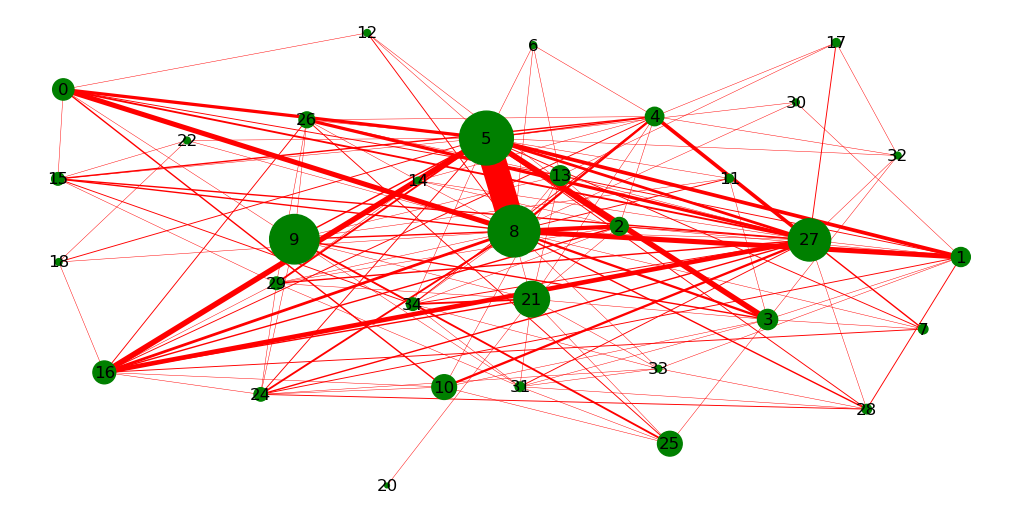

5
{0: 0.8506747932085329, 1: 0.6652154984762734, 2: 0.5798868088811493, 3: 0.5359164127122333, 4: 0.4114061819764911, 5: 0.3952982150631258, 6: 0.5245973008271658, 7: 0.24945581192860253, 8: 0.4606007836308228, 9: 0.19677840661732696, 10: 0.3413147583804963, 11: 0.32868959512407486, 12: 0.10535481062255116, 13: 0.23813670004353504, 14: 0.2799303439268611, 15: 0.15977361776229865, 16: 0.09360034828036569, 17: 0.19329560296038312, 18: 0.05616020896821942, 19: 0.08141053548106225, 20: 0.12233347845015237, 21: 0.1610796691336526, 22: 0.09621245102307358, 23: 0.052242054854157595, 24: 0.09969525468001741, 25: 0.11841532433609055, 26: 0.18154114061819765, 27: 0.19155420113191118, 28: 0.1262516325642142, 29: 0.15585546364823682, 30: 0.08402263822377014, 31: 0.0500653025685677, 32: 0.06573791902481498, 33: 0.07096212451023073, 34: 0.05964301262516326}
2297


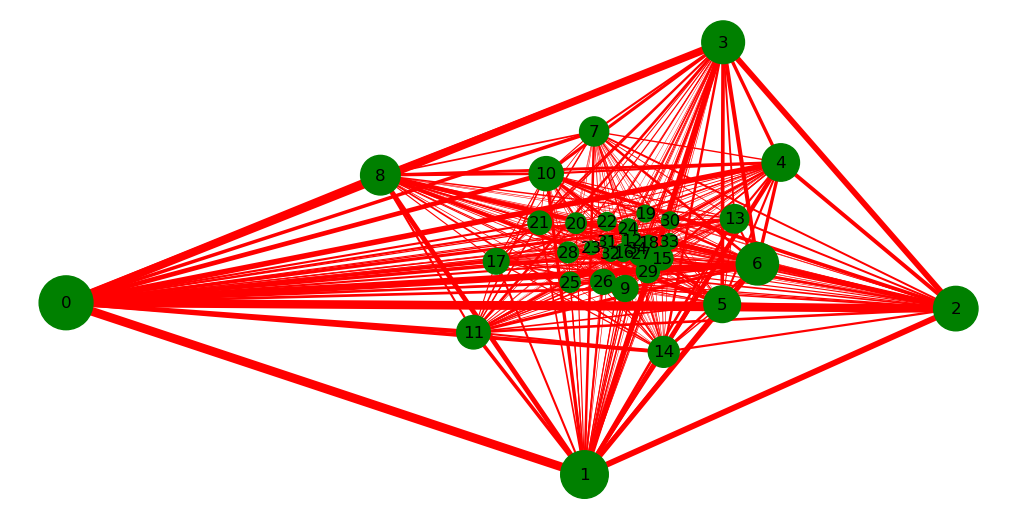

6
{0: 0.0, 1: 0.0, 2: 0.0, 3: 0.0, 4: 0.0, 5: 0.0, 6: 0.0, 7: 0.031746031746031744, 8: 0.0, 9: 0.0, 10: 0.0, 11: 0.0, 12: 0.0, 13: 0.007936507936507936, 14: 0.0, 15: 0.46825396825396826, 16: 0.0, 17: 0.0, 18: 0.007936507936507936, 19: 0.0, 20: 0.0, 21: 0.0, 22: 0.0, 23: 0.0, 24: 0.007936507936507936, 25: 0.0, 26: 0.5317460317460317, 27: 0.0, 28: 0.007936507936507936, 29: 0.0, 30: 0.0, 31: 0.0, 32: 0.0, 33: 0.0, 34: 0.0}
126


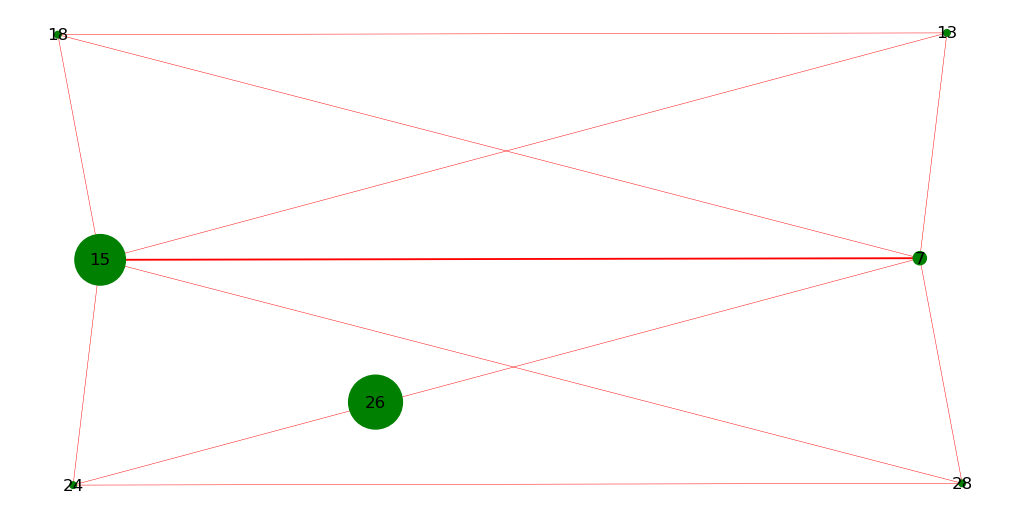

7
{0: 0.022900763358778626, 1: 0.03307888040712468, 2: 0.013994910941475827, 3: 0.13358778625954199, 4: 0.11323155216284987, 5: 0.010178117048346057, 6: 0.021628498727735368, 7: 0.05725190839694656, 8: 0.019083969465648856, 9: 0.030534351145038167, 10: 0.01272264631043257, 11: 0.007633587786259542, 12: 0.11959287531806616, 13: 0.005089058524173028, 14: 0.005089058524173028, 15: 0.04961832061068702, 16: 0.026717557251908396, 17: 0.01272264631043257, 18: 0.13104325699745548, 19: 0.058524173027989825, 20: 0.10305343511450382, 21: 0.003816793893129771, 22: 0.08142493638676845, 23: 0.09287531806615776, 24: 0.03816793893129771, 25: 0.0, 26: 0.01653944020356234, 27: 0.008905852417302799, 28: 0.003816793893129771, 29: 0.043256997455470736, 30: 0.026717557251908396, 31: 0.03816793893129771, 32: 0.003816793893129771, 33: 0.047073791348600506, 34: 0.16412213740458015}
786


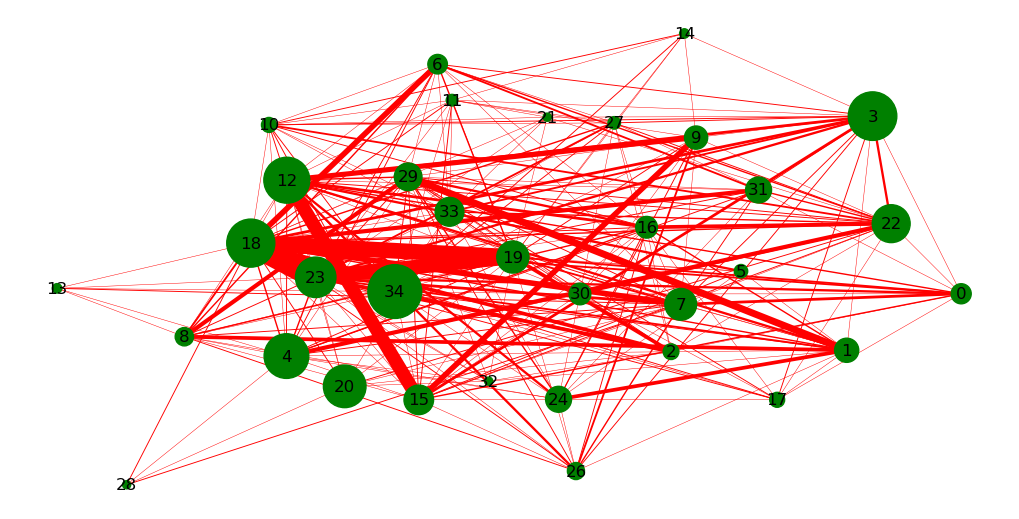

8
{0: 0.6871907641561298, 1: 0.35349092908191315, 2: 0.32160527762506874, 3: 0.35459043430456294, 4: 0.35404068169323805, 5: 0.3903243540406817, 6: 0.06212204507971413, 7: 0.22210005497526114, 8: 0.13523914238592633, 9: 0.45849367784496975, 10: 0.3644859813084112, 11: 0.23529411764705882, 12: 0.5508521165475536, 13: 0.27872457394172623, 14: 0.13908741066520067, 15: 0.35404068169323805, 16: 0.3243540406816932, 17: 0.1858163826278175, 18: 0.07366684991753711, 19: 0.0720175920835624, 20: 0.2034084661902144, 21: 0.102803738317757, 22: 0.12424409015942826, 23: 0.032985156679494226, 24: 0.28257284222100054, 25: 0.12754260582737767, 26: 0.07641561297416163, 27: 0.10335349092908191, 28: 0.08411214953271028, 29: 0.06597031335898845, 30: 0.08191313908741067, 31: 0.037383177570093455, 32: 0.13468938977460143, 33: 0.056624518966465094, 34: 0.04892798240791644}
1819


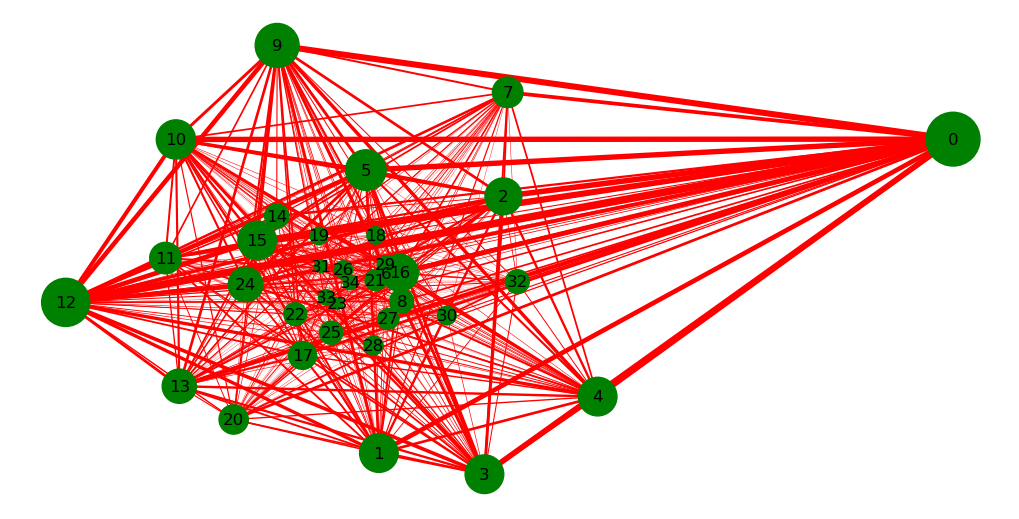

9
{0: 0.4425087108013937, 1: 0.33013937282229966, 2: 0.28310104529616725, 3: 0.20034843205574912, 4: 0.2465156794425087, 5: 0.06358885017421603, 6: 0.44337979094076657, 7: 0.023519163763066203, 8: 0.05836236933797909, 9: 0.14982578397212543, 10: 0.06010452961672474, 11: 0.11759581881533102, 12: 0.06968641114982578, 13: 0.05400696864111498, 14: 0.04442508710801394, 15: 0.06881533101045297, 16: 0.21080139372822299, 17: 0.04965156794425087, 18: 0.0156794425087108, 19: 0.02613240418118467, 20: 0.13763066202090593, 21: 0.09146341463414634, 22: 0.06533101045296168, 23: 0.014808362369337979, 24: 0.041811846689895474, 25: 0.039198606271777, 26: 0.10452961672473868, 27: 0.06445993031358885, 28: 0.04529616724738676, 29: 0.032229965156794424, 30: 0.040940766550522645, 31: 0.0156794425087108, 32: 0.029616724738675958, 33: 0.06097560975609756, 34: 0.08885017421602788}
1148


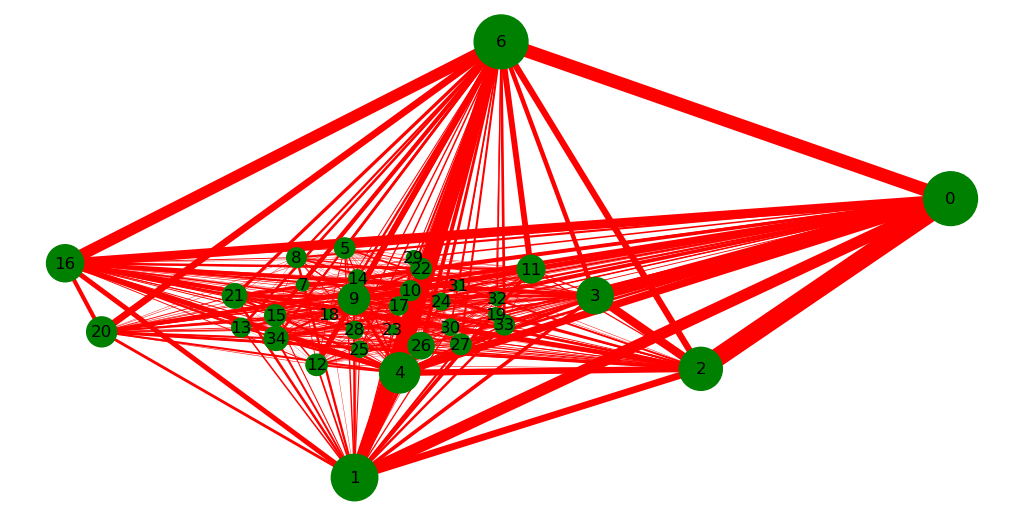

In [32]:
clusters = [old_data[k.labels_ == i] for i in range(n_clusters)]
for see_cluster in range(n_clusters):
    print(see_cluster)
#     print(np.where(np.mean(clusters[see_cluster],0) > 0.75)[0])
    print({i:x for i,x in enumerate(np.mean(clusters[see_cluster],0))})
    print(len(clusters[see_cluster]))
    cluster_0 = Counter([tuple(np.where(x == 1)[0]) for x in clusters[see_cluster]])

    edge_dict = {}
    for key,value in cluster_0.items():
        for perm in permutations(key, 2):
            try:
                edge_dict[(perm[0], perm[1])] += value
            except KeyError:
                try: 
                    edge_dict[(perm[1], perm[0])] += value
                except KeyError:
                    edge_dict[(perm[0], perm[1])] = value

    edge_list = [(*key, {'weight':value}) for key,value in edge_dict.items()]
#     print([x for x in edge_list if x[2]['weight'] > 0.25*len(clusters[see_cluster])])

    G = nx.Graph()
    G.add_nodes_from(sorted(set([y for x in cluster_0.keys() for y in x])))
    G.add_edges_from(edge_list)
    rcParams['figure.figsize'] = 10, 5
    rcParams['figure.dpi'] = 100
    options = {
        'node_color': 'g',
        'edge_color':'r'
    }
    edges = G.edges()
    weights = [G[u][v]['weight'] for u,v in edges]
    weights /= np.median(weights)*3
    
    nodes = G.nodes()
    s = np.sum(clusters[see_cluster],0)
    s /= max(s)
    s *= 1500
    node_size = [s[n] for n in nodes]

    nx.draw_kamada_kawai(G, node_size=node_size, with_labels=True, edgelist=edges, width=weights, **options)
    plt.show()


In [29]:
sum(Profile(approval_profile_files[i][0]).ballots)

array([5079., 3502., 3118., 3028., 2504., 2384., 2276., 2105., 2057.,
       2052., 2025., 1705., 1701., 1624., 1430., 1405., 1323., 1289.,
       1256., 1223., 1114., 1098., 1001.,  996.,  974.,  969.,  953.,
        949.,  878.,  758.,  679.,  632.,  574.,  571.,  565.])